In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import torch
import torch_geometric as pyg
from tqdm.auto import *

from deepgd.model import Generator
from deepgd.data import GraphDrawingData
from deepgd.datasets import  RomeDataset

from deepgd.metrics import Stress

In [3]:
np.random.seed(721)
torch.manual_seed(721)
torch.cuda.manual_seed_all(721)

In [4]:
device = "cpu"
for backend, device_name in {
    torch.backends.mps: "mps",
    torch.cuda: "cuda",
}.items():
    if backend.is_available():
        device = device_name

/work/mlyang721/anaconda3/envs/deepgd/lib/python3.10/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [5]:
batch_size = 32
lr = 0.001
decay = 0.998

====================================================================================

##### ErdosRenyi Dataset

##### Rome Dataset

In [6]:
GraphDrawingData.set_optional_fields(["edge_pair_metaindex", "face", "rng"])
dataset = RomeDataset(
    index=pd.read_csv("assets/rome_index.txt", header=None)[0],
)
print(len(dataset))
layouts = np.load("assets/layouts/pmds.npy", allow_pickle=True)

inside init
raw_file_names
inside _parse_metadata


/work/mlyang721/anaconda3/envs/deepgd/lib/python3.10/site-packages/torch_geometric/data/dataset.py:213: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if osp.exists(f) and to

processed_file_names
processed_file_names
processed_file_names


Transform graphs:   0%|          | 0/347 [00:00<?, ?it/s]

data dictionary size: 347
Graph erdos_renyi_20_0.2_graph_0 not found
Graph erdos_renyi_20_0.2_graph_1 not found
Graph erdos_renyi_20_0.2_graph_6 not found
347


====================================================================================

In [7]:

params = Generator.Params(
    num_blocks=11,
    block_depth=3,
    block_width=8,
    block_output_dim=8,
    edge_net_depth=2,
    edge_net_width=16,
    edge_attr_dim=2,
    node_attr_dim=2,
)
model = Generator(
    params=params,
).to(device)
criteria = {
    Stress(): 1,
    # dgd.EdgeVar(): 0,
    # dgd.Occlusion(): 0,
    # dgd.IncidentAngle(): 0,
    # dgd.TSNEScore(): 0,
}

In [8]:
optim = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=decay)

In [9]:
datalist = list(dataset)
for i, data in enumerate(datalist):
    data.pos = torch.tensor(layouts[i]).float()

In [10]:
train_loader = pyg.loader.DataLoader(datalist[:10000], batch_size=batch_size, shuffle=True)
val_loader = pyg.loader.DataLoader(datalist[11000:], batch_size=batch_size, shuffle=False)
# test_loader = pyg.loader.DataLoader(datalist[10000:11000], batch_size=batch_size, shuffle=False)
test_loader = pyg.loader.DataLoader(datalist[:300], batch_size=batch_size, shuffle=False)

In [17]:
import networkx as nx
def generate_init_pos(batch):
    # pos = torch.rand_like(batch.pos)
    print("batch.G",batch.G)
    combined_graph = batch.G[4]
    # Combine each subsequent graph
    for g in batch.G[1:]:
        combined_graph = nx.disjoint_union(combined_graph, g)
    pos = rescale_by_stress(
        # pos = torch.tensor(list(nx.spectral_layout(nx.compose(*batch.G)).values()), dtype=torch.float32),
        pos = torch.tensor(list(nx.spectral_layout(combined_graph).values()), dtype=torch.float32),
        apsp=batch.apsp_attr,
        edge_index=batch.perm_index,
        batch_index=batch.batch,
    )
    print(" shape after rescale_by_stress:", pos.shape)
    return pos


def get_edge_features(all_pair_shortest_path):
    return torch.cat([
        all_pair_shortest_path[:, None],
        1 / all_pair_shortest_path[:, None].square()
    ], dim=-1)

# def rescale_by_stress(pos, apsp, edge_index, batch_index):  
#     src_pos, dst_pos = pos[edge_index[0]], pos[edge_index[1]]
#     dist = (dst_pos - src_pos).norm(dim=1)
#     u_over_d = dist / apsp
    
#     # Ensuring we cover all indices that pos might reference
#     max_index = pos.size(0)
#     scatterd_u_over_d_2 = pyg.utils.scatter(u_over_d ** 2, batch_index[edge_index[0]], dim_size=max_index)
#     scatterd_u_over_d = pyg.utils.scatter(u_over_d, batch_index[edge_index[0]], dim_size=max_index)

#     scale = scatterd_u_over_d_2 / scatterd_u_over_d
    
#     # print("pos shape:", pos.shape)
#     # print("scale shape:", scale.shape)
#     # print("adjusted scale shape for operation:", scale[batch_index][:, None].shape)
#     # print("Max edge index:", torch.max(edge_index).item())
#     # print("Number of positions available:", pos.size(0))

#     scaled_pos = pos / scale[:, None]
#     # print("Shape of scaled positions:", scaled_pos.shape)

#     return scaled_pos

def rescale_by_stress(pos, apsp, edge_index):  
    src_pos, dst_pos = pos[edge_index[0]], pos[edge_index[1]]
    dist = (dst_pos - src_pos).norm(dim=1)
    
    # 避免除以零
    mask = apsp != 0
    if mask.sum() == 0:
        return pos  # 如果所有 apsp 都为零，直接返回原始位置
    u_over_d = dist[mask] / apsp[mask]
    
    # 计算缩放因子
    numerator = pyg.utils.scatter(u_over_d ** 2, edge_index[0][mask], dim_size=pos.size(0))
    denominator = pyg.utils.scatter(u_over_d, edge_index[0][mask], dim_size=pos.size(0))
    scale = numerator / denominator
    
    # 避免缩放因子为零
    scale[scale == 0] = 1.0
    
    scaled_pos = pos / scale[:, None]
    return scaled_pos


In [18]:
import torch
import networkx as nx

def generate_init_pos(batch):
    print("batch.G", batch.G)
    pos_list = []
    for i, g in enumerate(batch.G):
        print(f"Processing graph {i} with {g.number_of_nodes()} nodes and {g.number_of_edges()} edges.")
        try:
            if g.number_of_nodes() == 0:
                pos_tensor = torch.empty((0, 2))
            elif g.number_of_nodes() == 1:
                pos_tensor = torch.zeros((1, 2))
            else:
                # 移除自环
                g.remove_edges_from(nx.selfloop_edges(g))
                # 将有向图转换为无向图
                g_undirected = g.to_undirected()
                pos = nx.spectral_layout(g_undirected, dim=2)
                pos_tensor = torch.tensor(list(pos.values()), dtype=torch.float32)
        except Exception as e:
            print(f"Error computing spectral layout for graph {i}: {e}")
            # 使用随机初始化作为备用
            pos_tensor = torch.randn(g.number_of_nodes(), 2)
        pos_list.append(pos_tensor)
    pos = torch.cat(pos_list, dim=0)

    # 调用 rescale_by_stress 函数，确保参数名称一致
    pos = rescale_by_stress(
        pos=pos,
        apsp=batch.apsp_attr,
        edge_index=batch.perm_index,
        batch_index=batch.batch,
    )
    print("Shape after rescale_by_stress:", pos.shape)
    return pos

def rescale_by_stress(pos, apsp, edge_index, batch_index):  
    src_pos, dst_pos = pos[edge_index[0]], pos[edge_index[1]]
    dist = (dst_pos - src_pos).norm(dim=1)
    u_over_d = dist / apsp

    # Ensuring we cover all indices that pos might reference
    max_index = pos.size(0)
    scattered_u_over_d_2 = pyg.utils.scatter(u_over_d ** 2, batch_index[edge_index[0]], dim_size=max_index)
    scattered_u_over_d = pyg.utils.scatter(u_over_d, batch_index[edge_index[0]], dim_size=max_index)

    scale = scattered_u_over_d_2 / scattered_u_over_d

    scaled_pos = pos / scale[:, None]

    return scaled_pos


In [19]:
model.load_state_dict(torch.load("model_359.pt", map_location=device))

/tmp/ipykernel_10195/3491819972.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model_359.pt", map_location=device))


<All keys matched successfully>

In [20]:
# for epoch in range(1000):
for epoch in range(0):
    model.train()
    losses = []
    for batch in tqdm(train_loader):
        batch = batch.to(device)
        model.zero_grad()
        loss = 0
        for c, w in criteria.items():
            pred = model(
                init_pos=generate_init_pos(batch),
                edge_index=batch.perm_index,
                edge_attr=get_edge_features(batch.apsp_attr),
                batch_index=batch.batch,
            )
            pos = rescale_by_stress(pred, batch.apsp_attr, batch.perm_index, batch.batch)
            loss += w * c(pos, batch.perm_index, batch.apsp_attr, batch.batch)
        loss.backward()
        optim.step()
        losses.append(loss.item())
    scheduler.step()
    print(f'[Epoch {epoch}] Train Loss: {np.mean(losses)}')
    with torch.no_grad():
        model.eval()
        losses = []
        for batch in tqdm(val_loader, disable=True):
            batch = batch.to(device)
            loss = 0
            for c, w in criteria.items():
                pred = model(
                    init_pos=generate_init_pos(batch),
                    edge_index=batch.perm_index,
                    edge_attr=get_edge_features(batch.apsp_attr),
                    batch_index=batch.batch,
                )
                pos = rescale_by_stress(pred, batch.apsp_attr, batch.perm_index, batch.batch)
                loss += w * c(pos, batch.perm_index, batch.apsp_attr, batch.batch)
            losses.append(loss.item())
        print(f'[Epoch {epoch}] Val Loss: {np.mean(losses)}')

================================ DEBUG ================================

batch.G [<networkx.classes.digraph.DiGraph object at 0x7f9b74c64790>, <networkx.classes.digraph.DiGraph object at 0x7f9b74c659f0>, <networkx.classes.digraph.DiGraph object at 0x7f9b74c66800>, <networkx.classes.digraph.DiGraph object at 0x7f9b74c641c0>, <networkx.classes.digraph.DiGraph object at 0x7f9b74c66860>, <networkx.classes.digraph.DiGraph object at 0x7f9b74c668f0>, <networkx.classes.digraph.DiGraph object at 0x7f9b74c66980>, <networkx.classes.digraph.DiGraph object at 0x7f9b74c66a10>, <networkx.classes.digraph.DiGraph object at 0x7f9b74c66aa0>, <networkx.classes.digraph.DiGraph object at 0x7f9b74c66b30>, <networkx.classes.digraph.DiGraph object at 0x7f9b74c66bc0>, <networkx.classes.digraph.DiGraph object at 0x7f9b74c66c50>, <networkx.classes.digraph.DiGraph object at 0x7f9b74c66ce0>, <networkx.classes.digraph.DiGraph object at 0x7f9b74c66d70>, <networkx.classes.digraph.DiGraph object at 0x7f9b74c66e00>, <networkx.classes.digraph.DiGraph object at 0x7f9b74c66e90>, <networkx.class

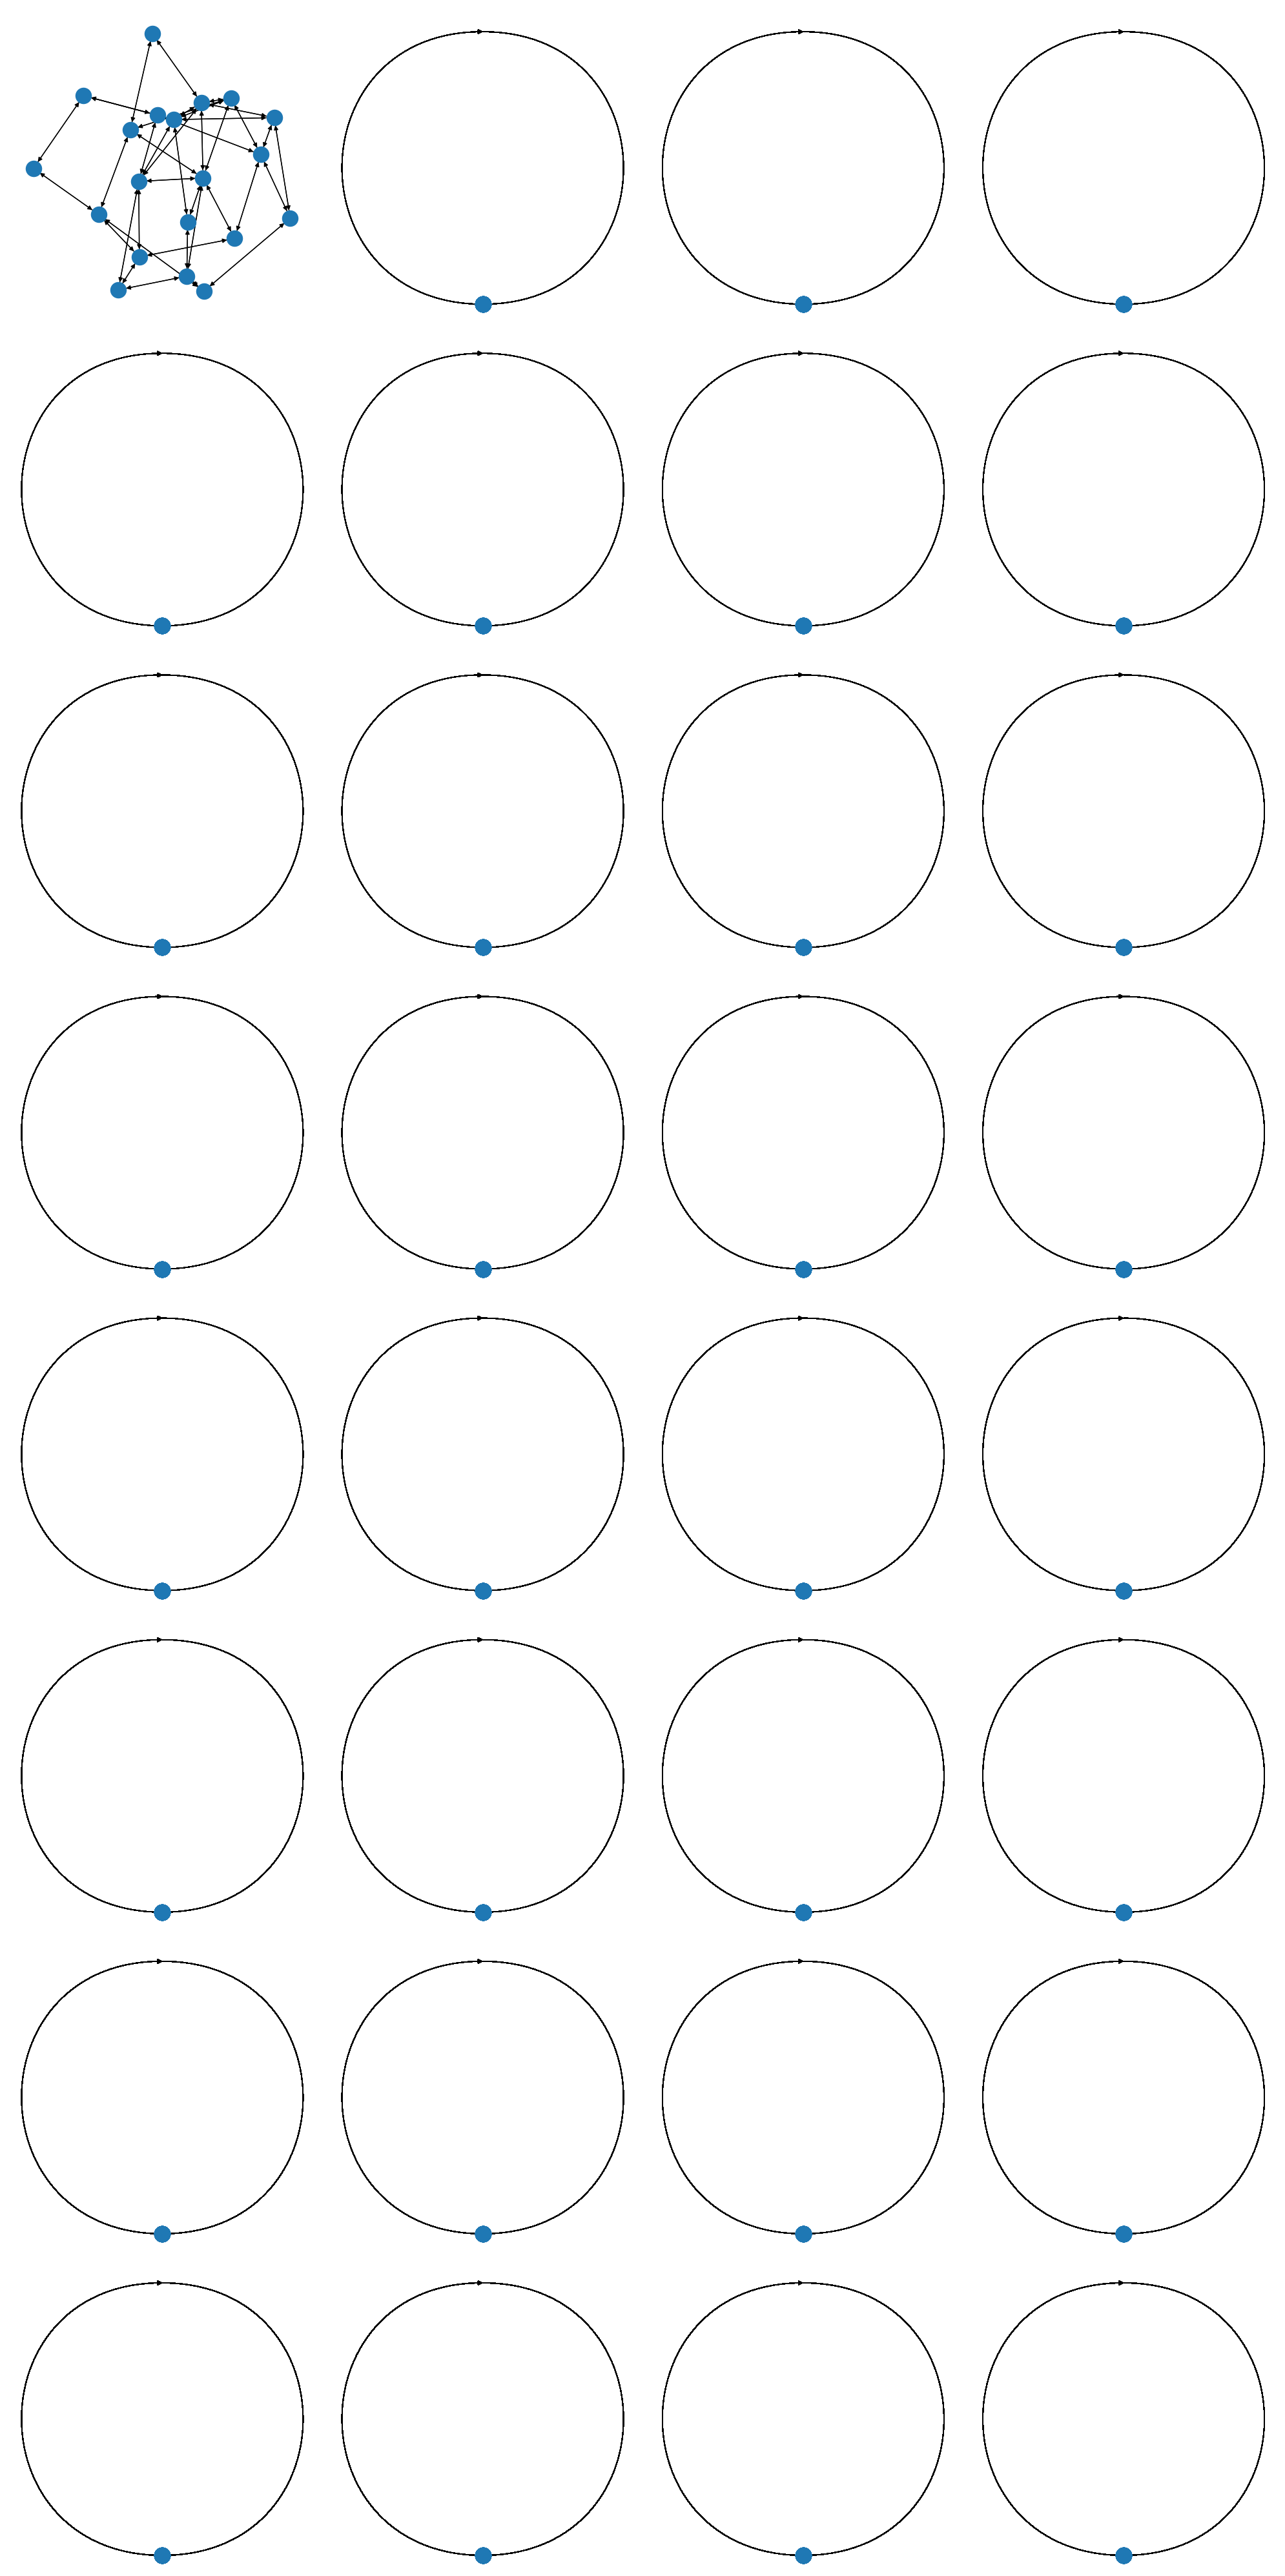

batch.G [<networkx.classes.digraph.DiGraph object at 0x7f9b74c67820>, <networkx.classes.digraph.DiGraph object at 0x7f9b74c678b0>, <networkx.classes.digraph.DiGraph object at 0x7f9b74c67940>, <networkx.classes.digraph.DiGraph object at 0x7f9b74c679d0>, <networkx.classes.digraph.DiGraph object at 0x7f9b74c67a60>, <networkx.classes.digraph.DiGraph object at 0x7f9b74c67af0>, <networkx.classes.digraph.DiGraph object at 0x7f9b74c67b80>, <networkx.classes.digraph.DiGraph object at 0x7f9b74c67c10>, <networkx.classes.digraph.DiGraph object at 0x7f9b74c67ca0>, <networkx.classes.digraph.DiGraph object at 0x7f9b74c67d30>, <networkx.classes.digraph.DiGraph object at 0x7f9b74c67dc0>, <networkx.classes.digraph.DiGraph object at 0x7f9b74c67e50>, <networkx.classes.digraph.DiGraph object at 0x7f9b74c67ee0>, <networkx.classes.digraph.DiGraph object at 0x7f9b74c67f70>, <networkx.classes.digraph.DiGraph object at 0x7f9b74288040>, <networkx.classes.digraph.DiGraph object at 0x7f9b742880d0>, <networkx.class

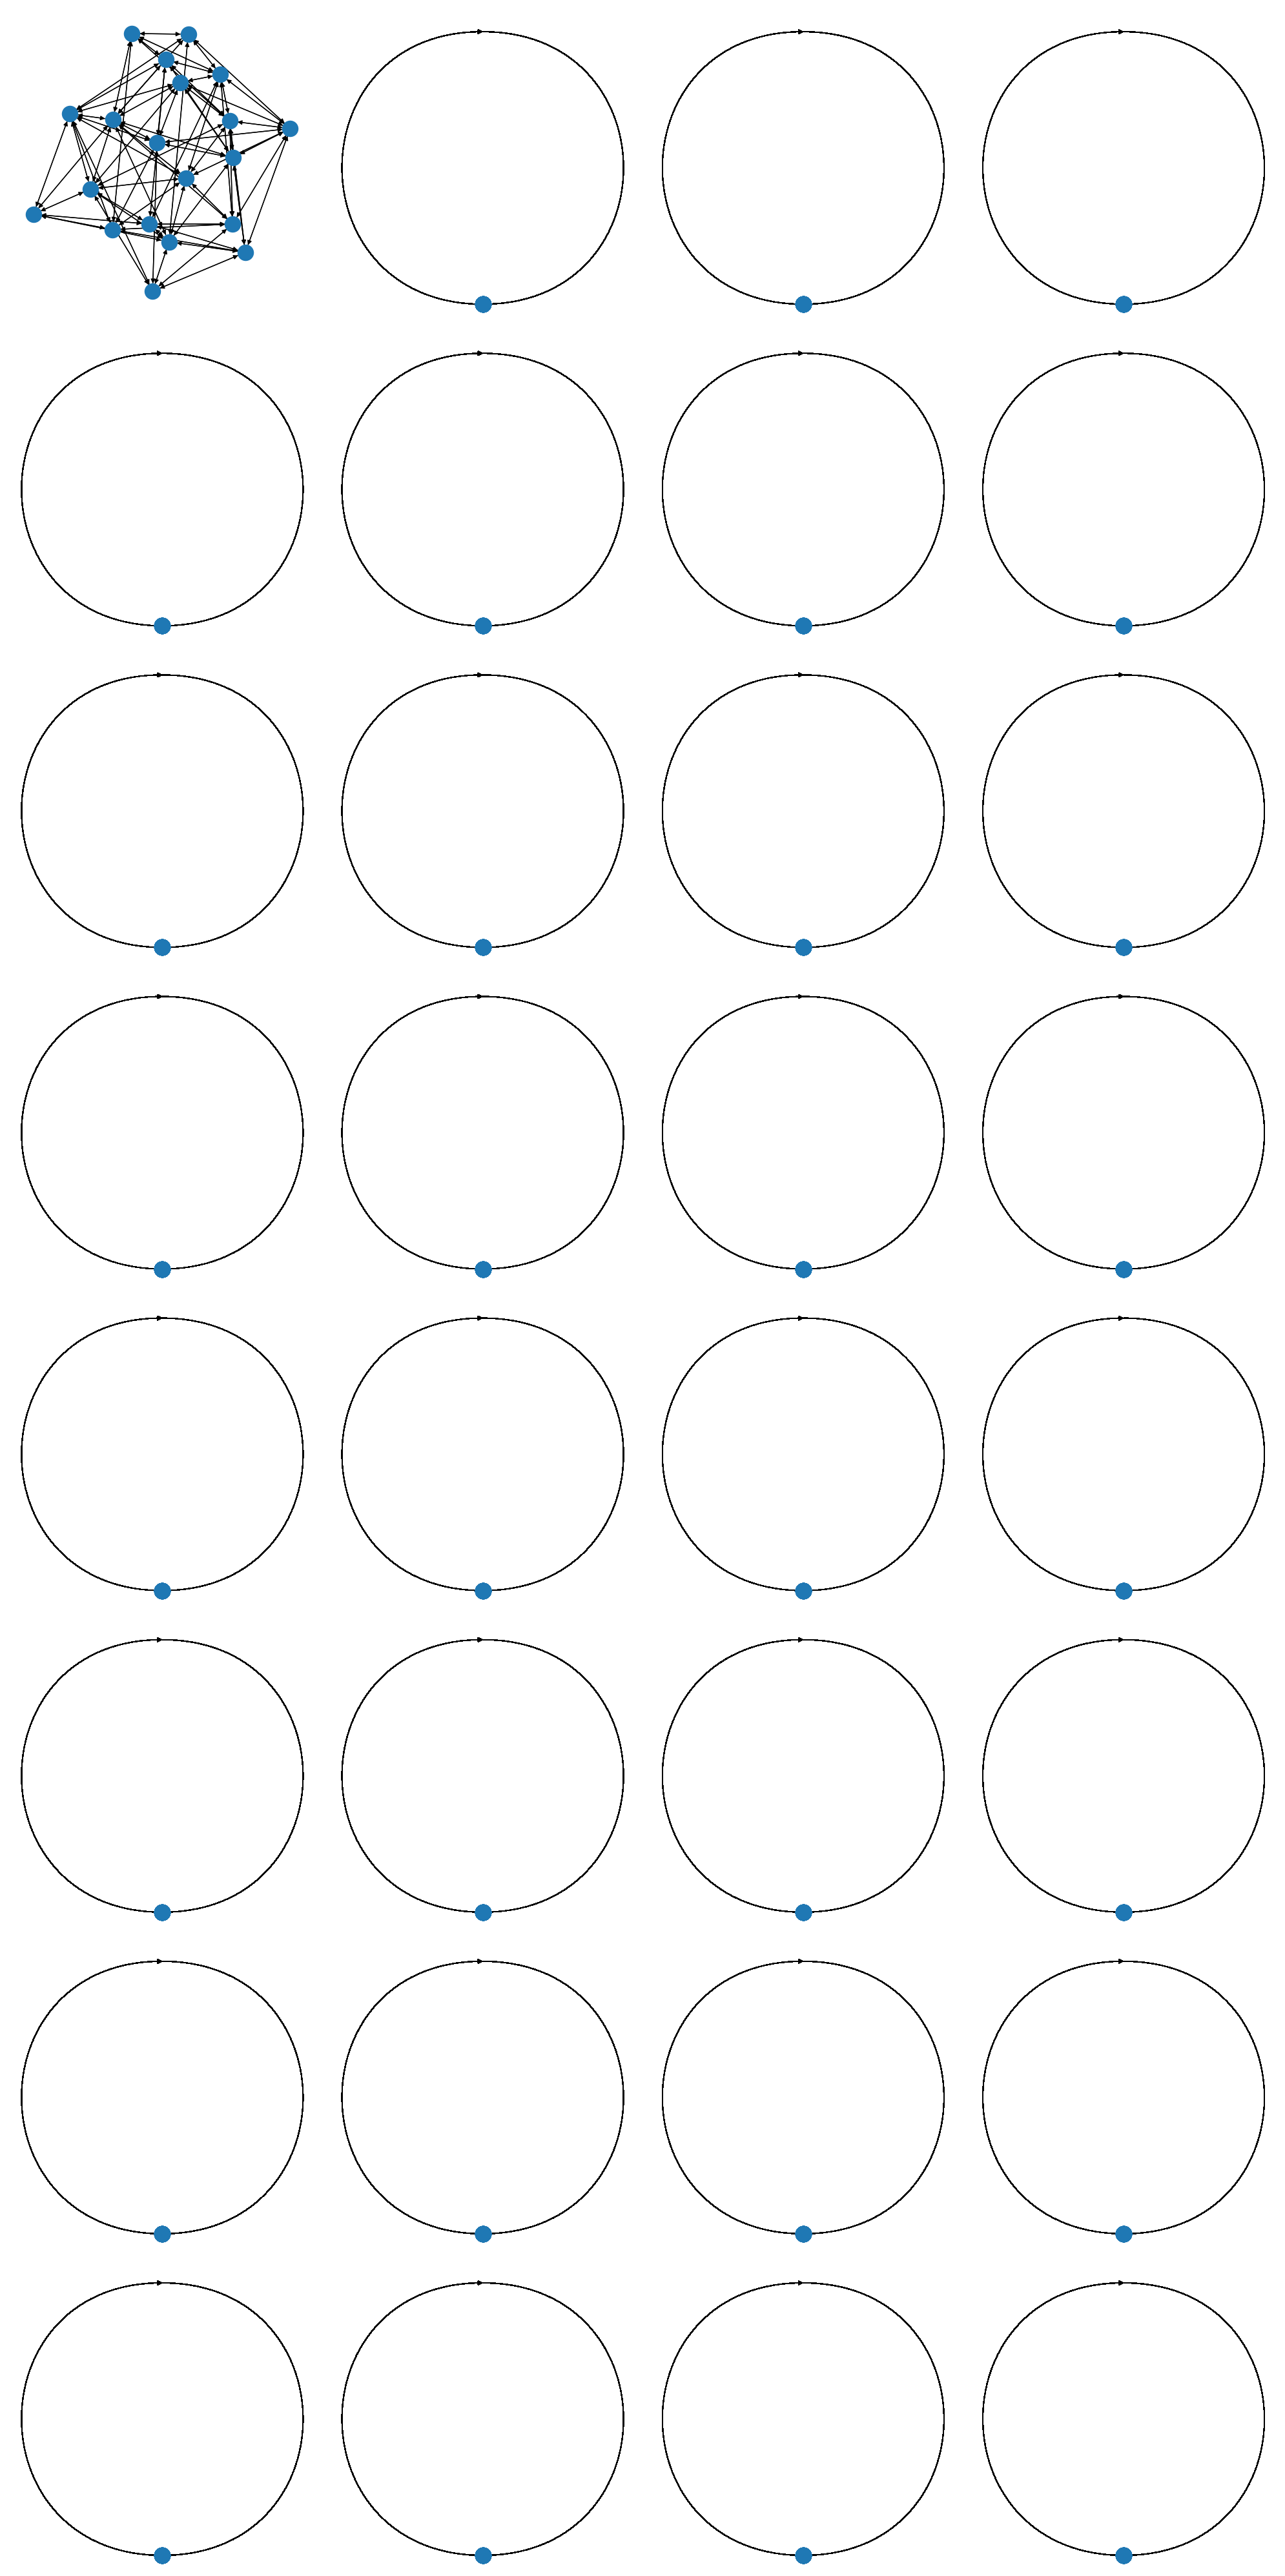

batch.G [<networkx.classes.digraph.DiGraph object at 0x7f9b74288a60>, <networkx.classes.digraph.DiGraph object at 0x7f9b74288af0>, <networkx.classes.digraph.DiGraph object at 0x7f9b74288b80>, <networkx.classes.digraph.DiGraph object at 0x7f9b74288c10>, <networkx.classes.digraph.DiGraph object at 0x7f9b74288ca0>, <networkx.classes.digraph.DiGraph object at 0x7f9b74288d30>, <networkx.classes.digraph.DiGraph object at 0x7f9b74288dc0>, <networkx.classes.digraph.DiGraph object at 0x7f9b74288e50>, <networkx.classes.digraph.DiGraph object at 0x7f9b74288ee0>, <networkx.classes.digraph.DiGraph object at 0x7f9b74288f70>, <networkx.classes.digraph.DiGraph object at 0x7f9b74289000>, <networkx.classes.digraph.DiGraph object at 0x7f9b74289090>, <networkx.classes.digraph.DiGraph object at 0x7f9b74289120>, <networkx.classes.digraph.DiGraph object at 0x7f9b742891b0>, <networkx.classes.digraph.DiGraph object at 0x7f9b74289240>, <networkx.classes.digraph.DiGraph object at 0x7f9b742892d0>, <networkx.class

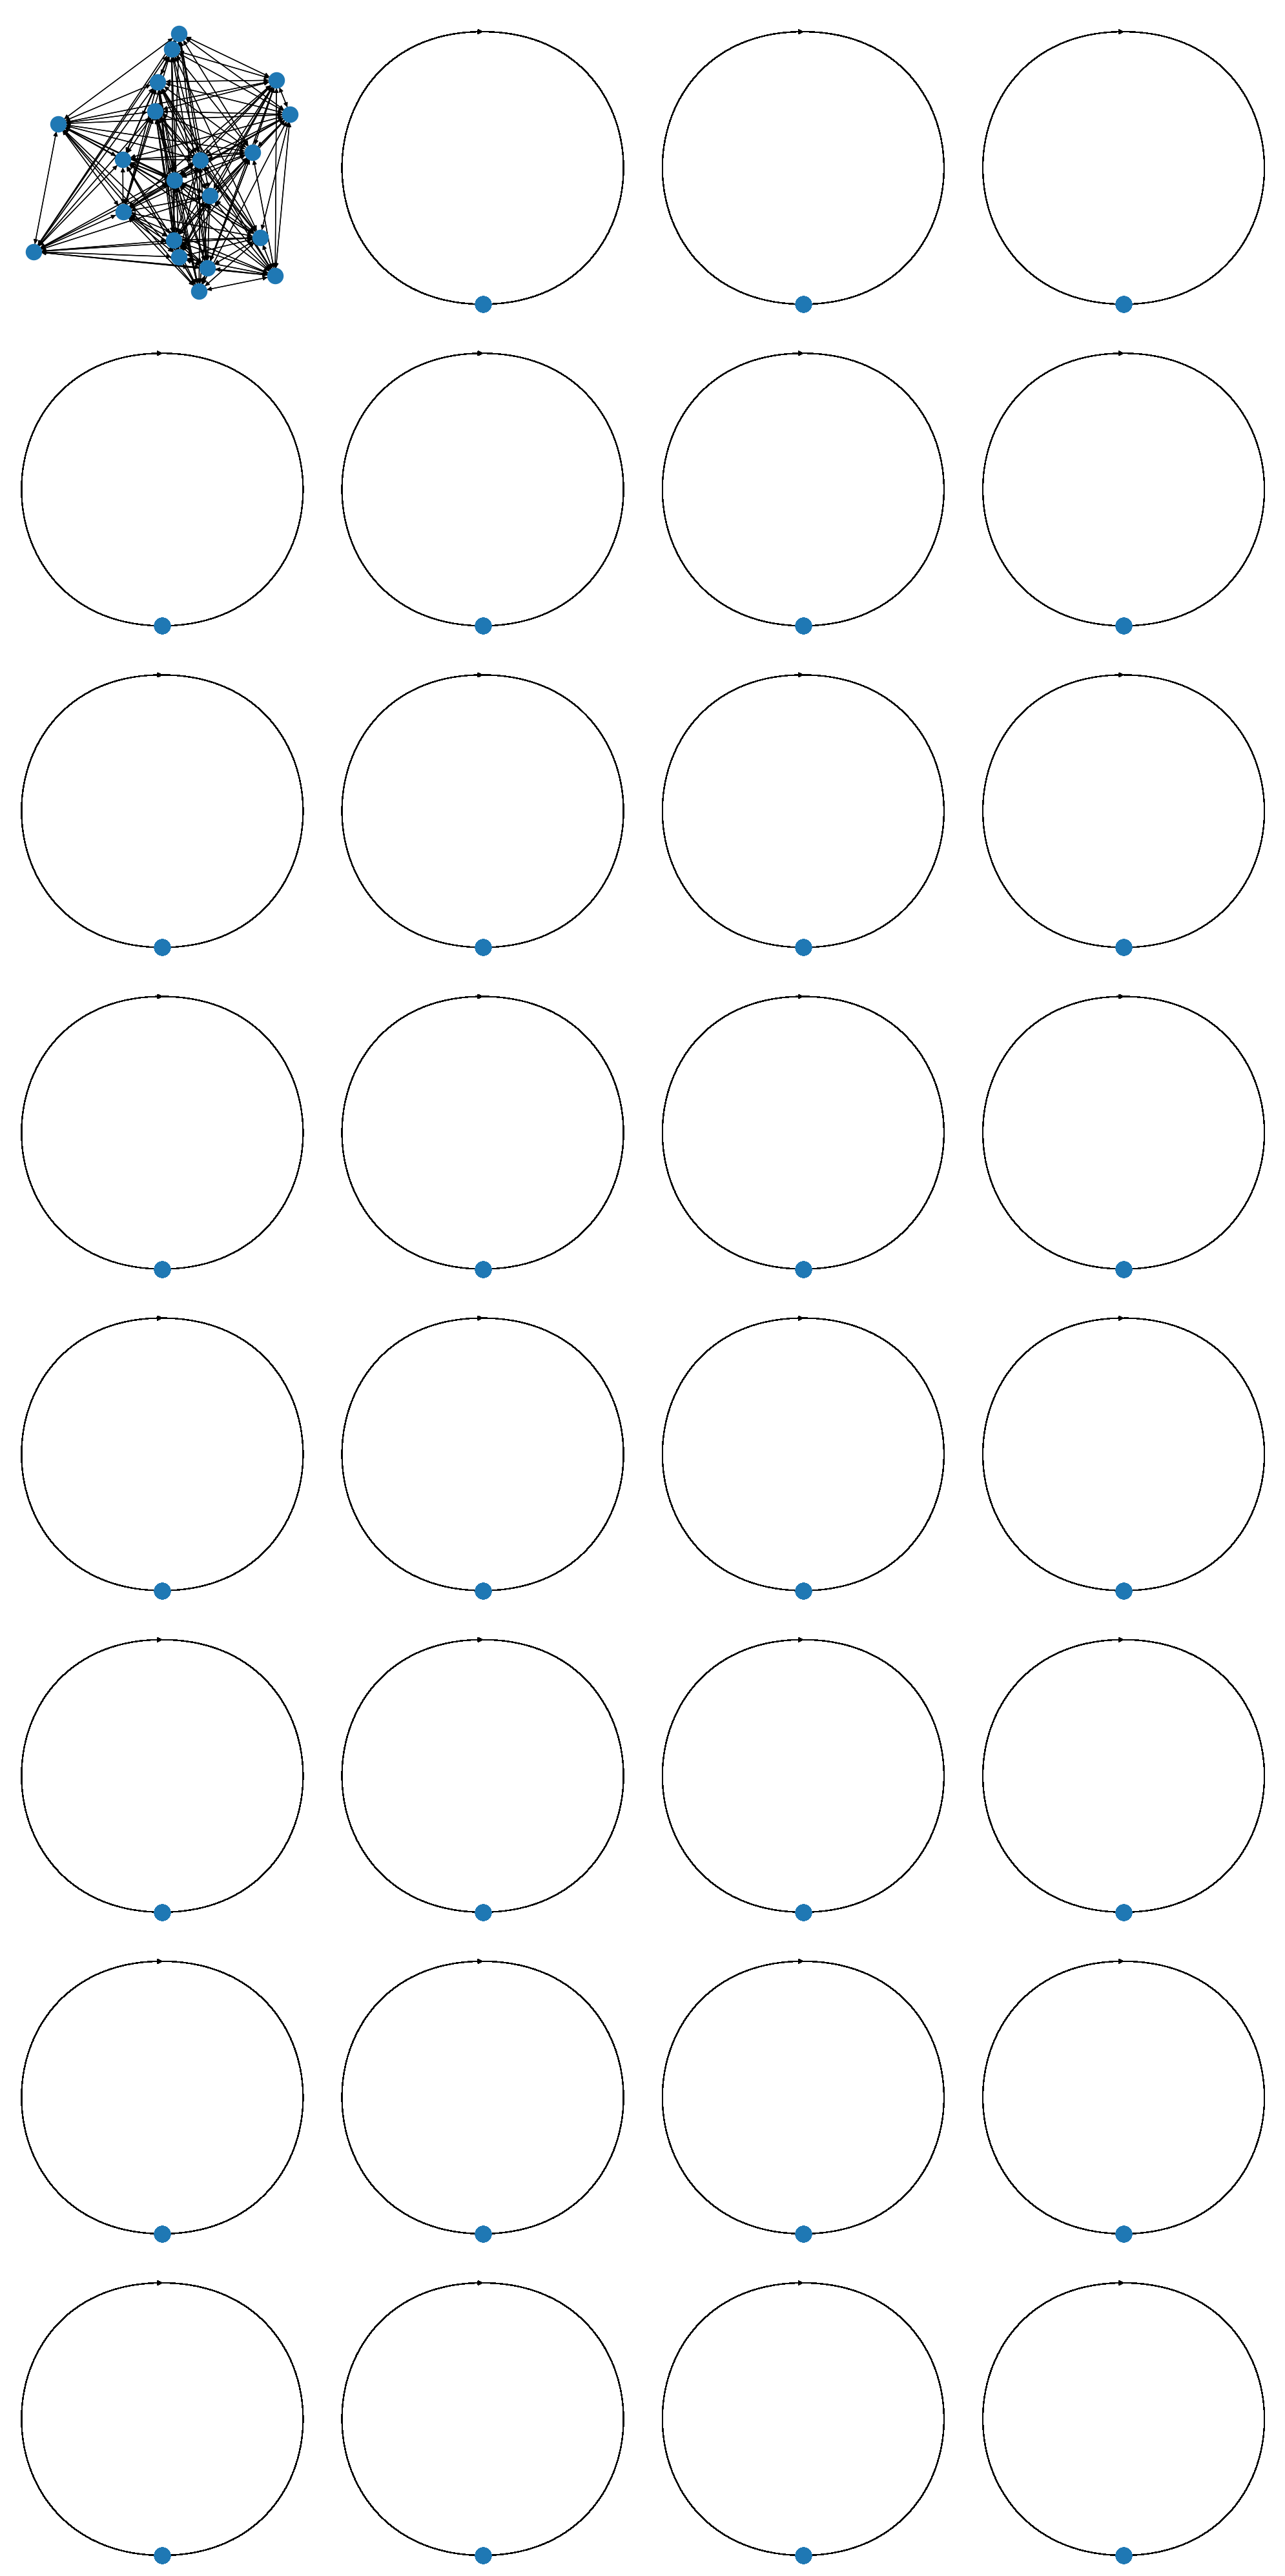

batch.G [<networkx.classes.digraph.DiGraph object at 0x7f9b74289c60>, <networkx.classes.digraph.DiGraph object at 0x7f9b74289cf0>, <networkx.classes.digraph.DiGraph object at 0x7f9b74289d80>, <networkx.classes.digraph.DiGraph object at 0x7f9b74289e10>, <networkx.classes.digraph.DiGraph object at 0x7f9b74289ea0>, <networkx.classes.digraph.DiGraph object at 0x7f9b74289f30>, <networkx.classes.digraph.DiGraph object at 0x7f9b74289fc0>, <networkx.classes.digraph.DiGraph object at 0x7f9b7428a050>, <networkx.classes.digraph.DiGraph object at 0x7f9b7428a0e0>, <networkx.classes.digraph.DiGraph object at 0x7f9b7428a170>, <networkx.classes.digraph.DiGraph object at 0x7f9b7428a200>, <networkx.classes.digraph.DiGraph object at 0x7f9b7428a290>, <networkx.classes.digraph.DiGraph object at 0x7f9b7428a320>, <networkx.classes.digraph.DiGraph object at 0x7f9b7428a3b0>, <networkx.classes.digraph.DiGraph object at 0x7f9b7428a440>, <networkx.classes.digraph.DiGraph object at 0x7f9b7428a4d0>, <networkx.class

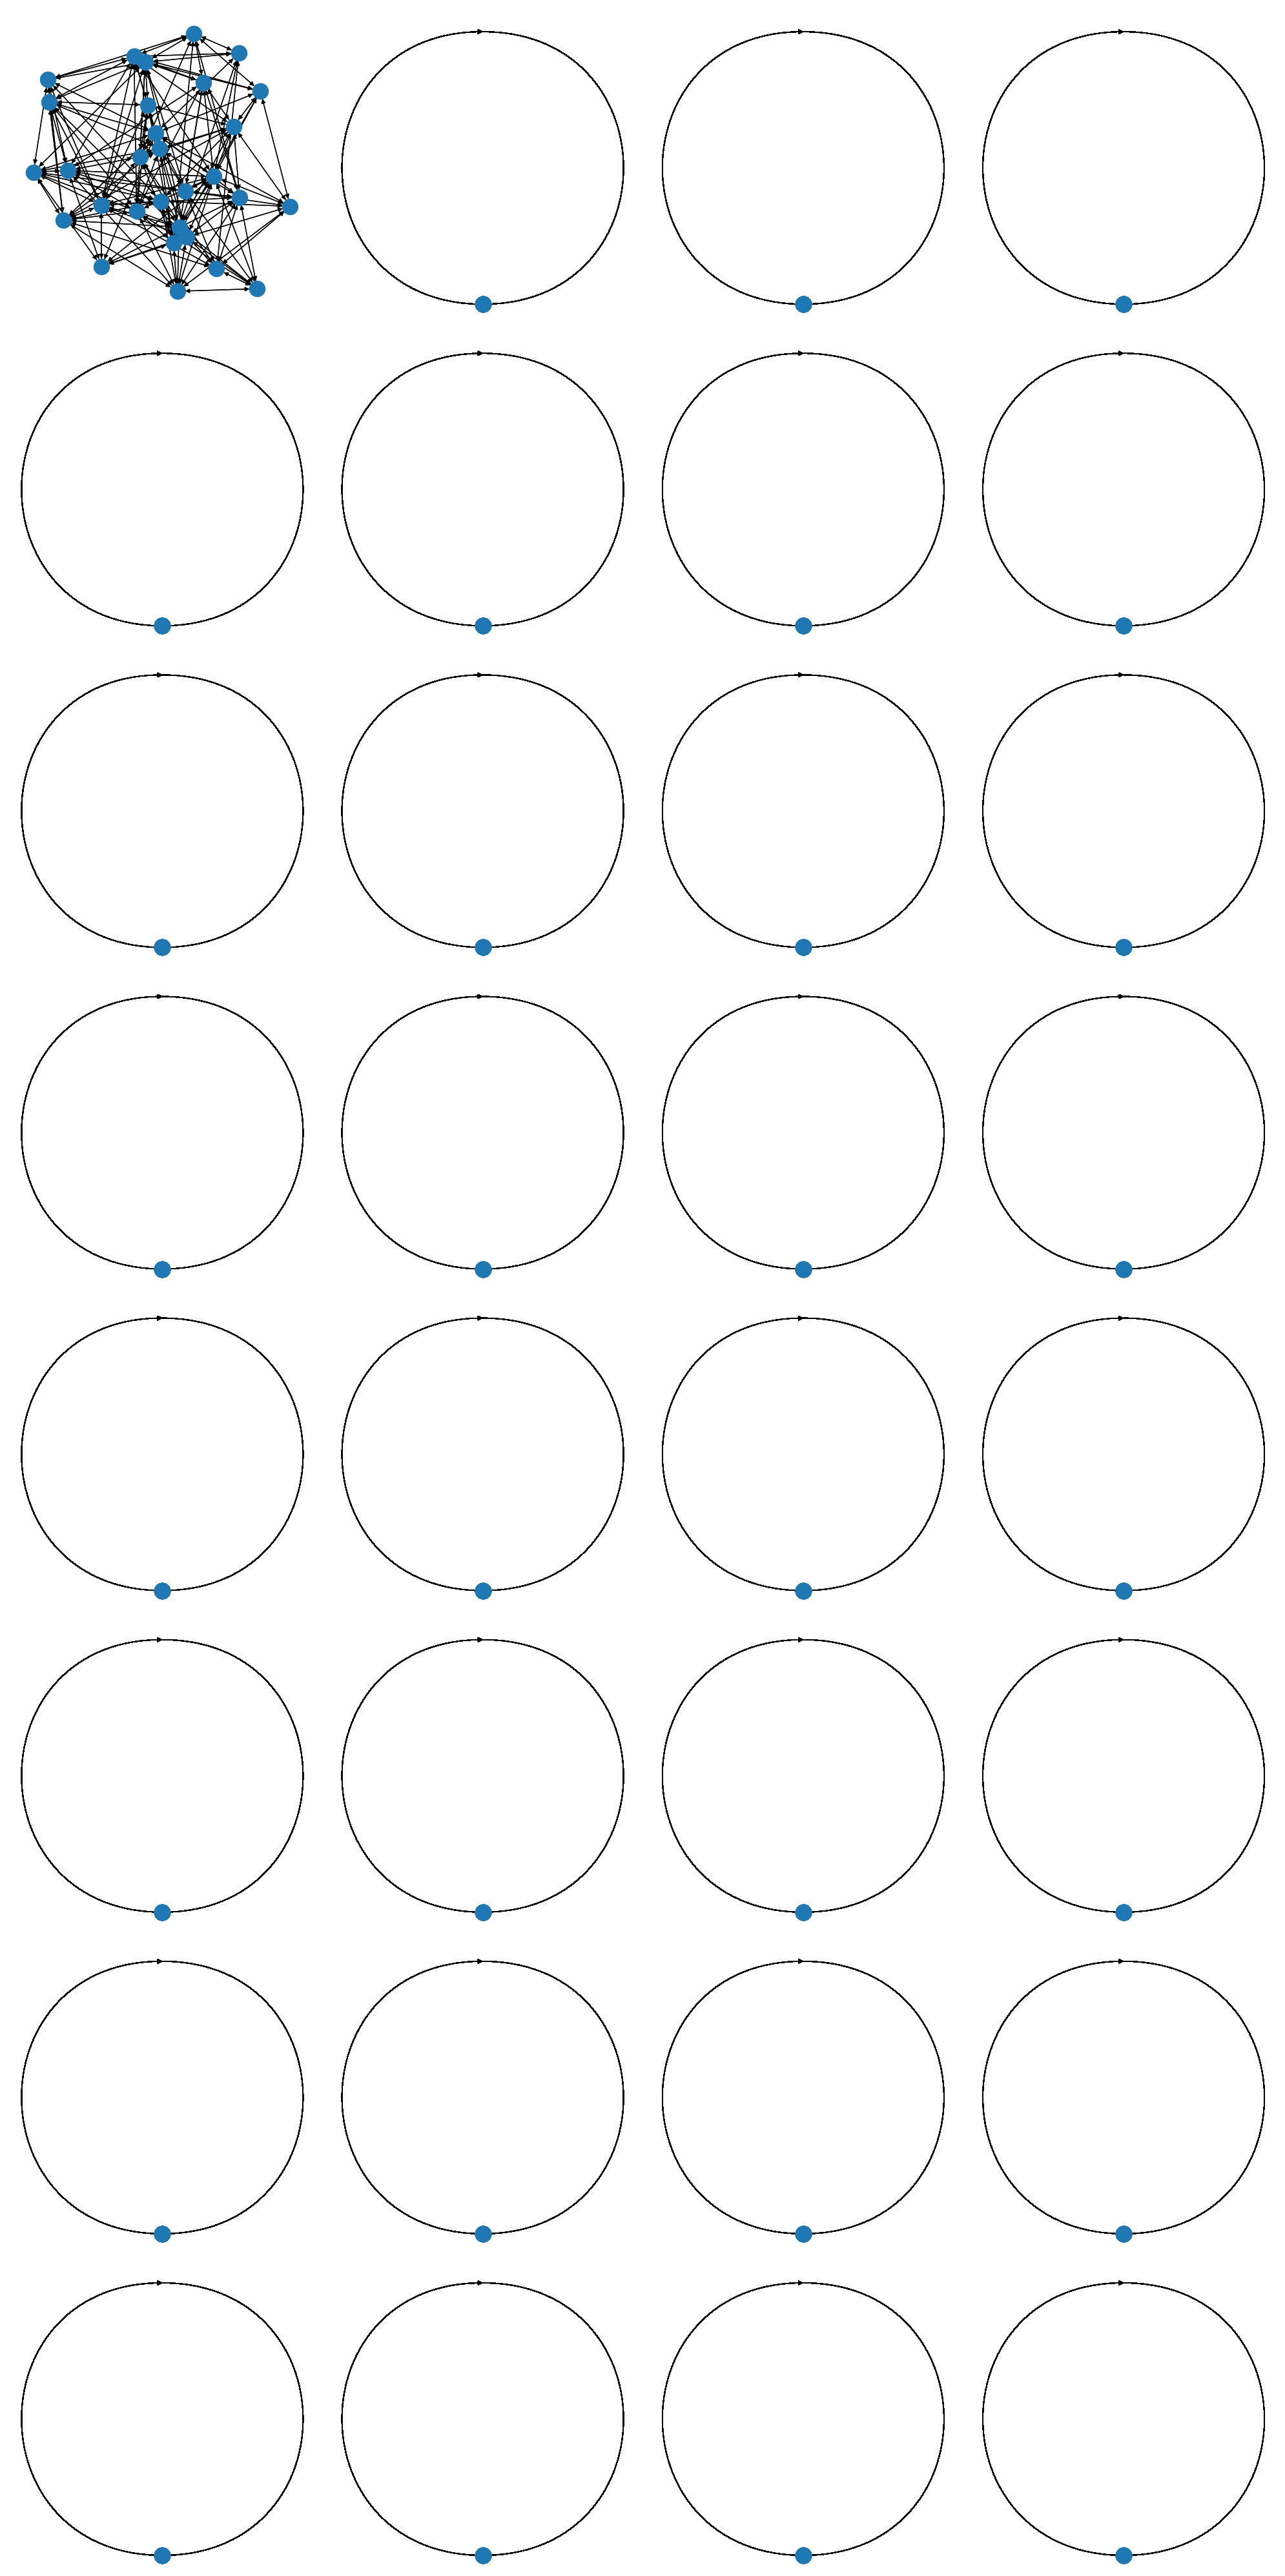

batch.G [<networkx.classes.digraph.DiGraph object at 0x7f9b7428ae60>, <networkx.classes.digraph.DiGraph object at 0x7f9b7428aef0>, <networkx.classes.digraph.DiGraph object at 0x7f9b7428af80>, <networkx.classes.digraph.DiGraph object at 0x7f9b7428b010>, <networkx.classes.digraph.DiGraph object at 0x7f9b7428b0a0>, <networkx.classes.digraph.DiGraph object at 0x7f9b7428b130>, <networkx.classes.digraph.DiGraph object at 0x7f9b7428b1c0>, <networkx.classes.digraph.DiGraph object at 0x7f9b7428b250>, <networkx.classes.digraph.DiGraph object at 0x7f9b7428b2e0>, <networkx.classes.digraph.DiGraph object at 0x7f9b7428b370>, <networkx.classes.digraph.DiGraph object at 0x7f9b7428b400>, <networkx.classes.digraph.DiGraph object at 0x7f9b7428b490>, <networkx.classes.digraph.DiGraph object at 0x7f9b7428b520>, <networkx.classes.digraph.DiGraph object at 0x7f9b7428b5b0>, <networkx.classes.digraph.DiGraph object at 0x7f9b7428b640>, <networkx.classes.digraph.DiGraph object at 0x7f9b7428b6d0>, <networkx.class

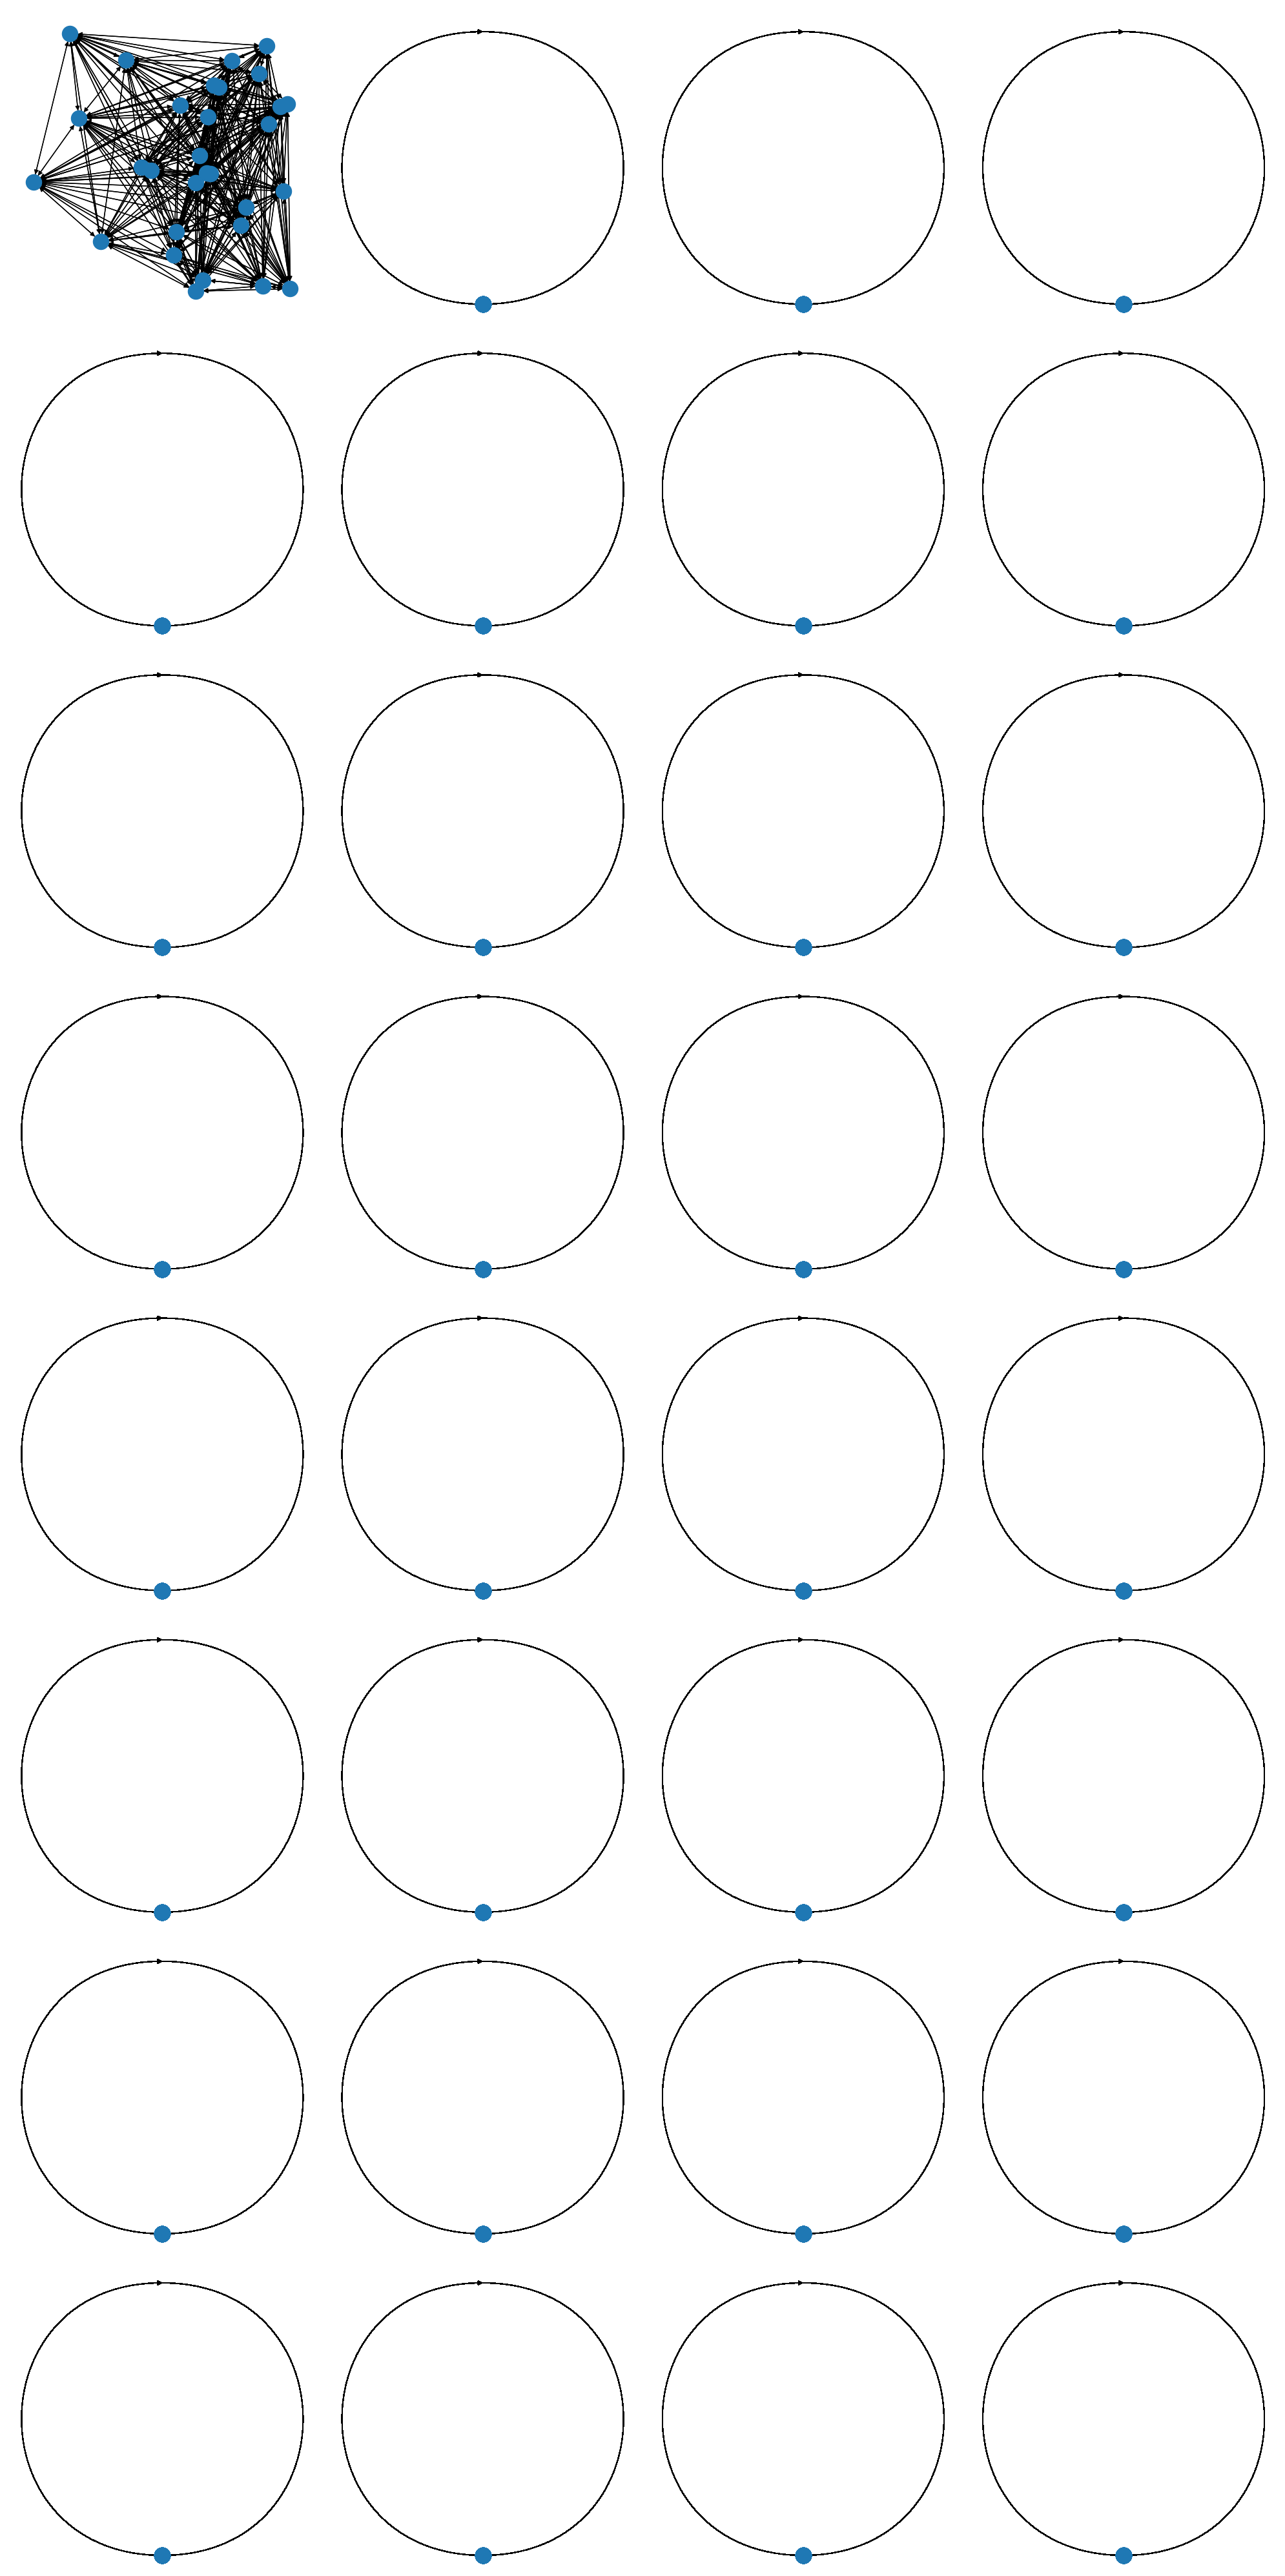

batch.G [<networkx.classes.digraph.DiGraph object at 0x7f9b735dc0a0>, <networkx.classes.digraph.DiGraph object at 0x7f9b735dc130>, <networkx.classes.digraph.DiGraph object at 0x7f9b735dc1c0>, <networkx.classes.digraph.DiGraph object at 0x7f9b735dc250>, <networkx.classes.digraph.DiGraph object at 0x7f9b735dc2e0>, <networkx.classes.digraph.DiGraph object at 0x7f9b735dc370>, <networkx.classes.digraph.DiGraph object at 0x7f9b735dc400>, <networkx.classes.digraph.DiGraph object at 0x7f9b735dc490>, <networkx.classes.digraph.DiGraph object at 0x7f9b735dc520>, <networkx.classes.digraph.DiGraph object at 0x7f9b735dc5b0>, <networkx.classes.digraph.DiGraph object at 0x7f9b735dc640>, <networkx.classes.digraph.DiGraph object at 0x7f9b735dc6d0>, <networkx.classes.digraph.DiGraph object at 0x7f9b735dc760>, <networkx.classes.digraph.DiGraph object at 0x7f9b735dc7f0>, <networkx.classes.digraph.DiGraph object at 0x7f9b735dc880>, <networkx.classes.digraph.DiGraph object at 0x7f9b735dc910>, <networkx.class

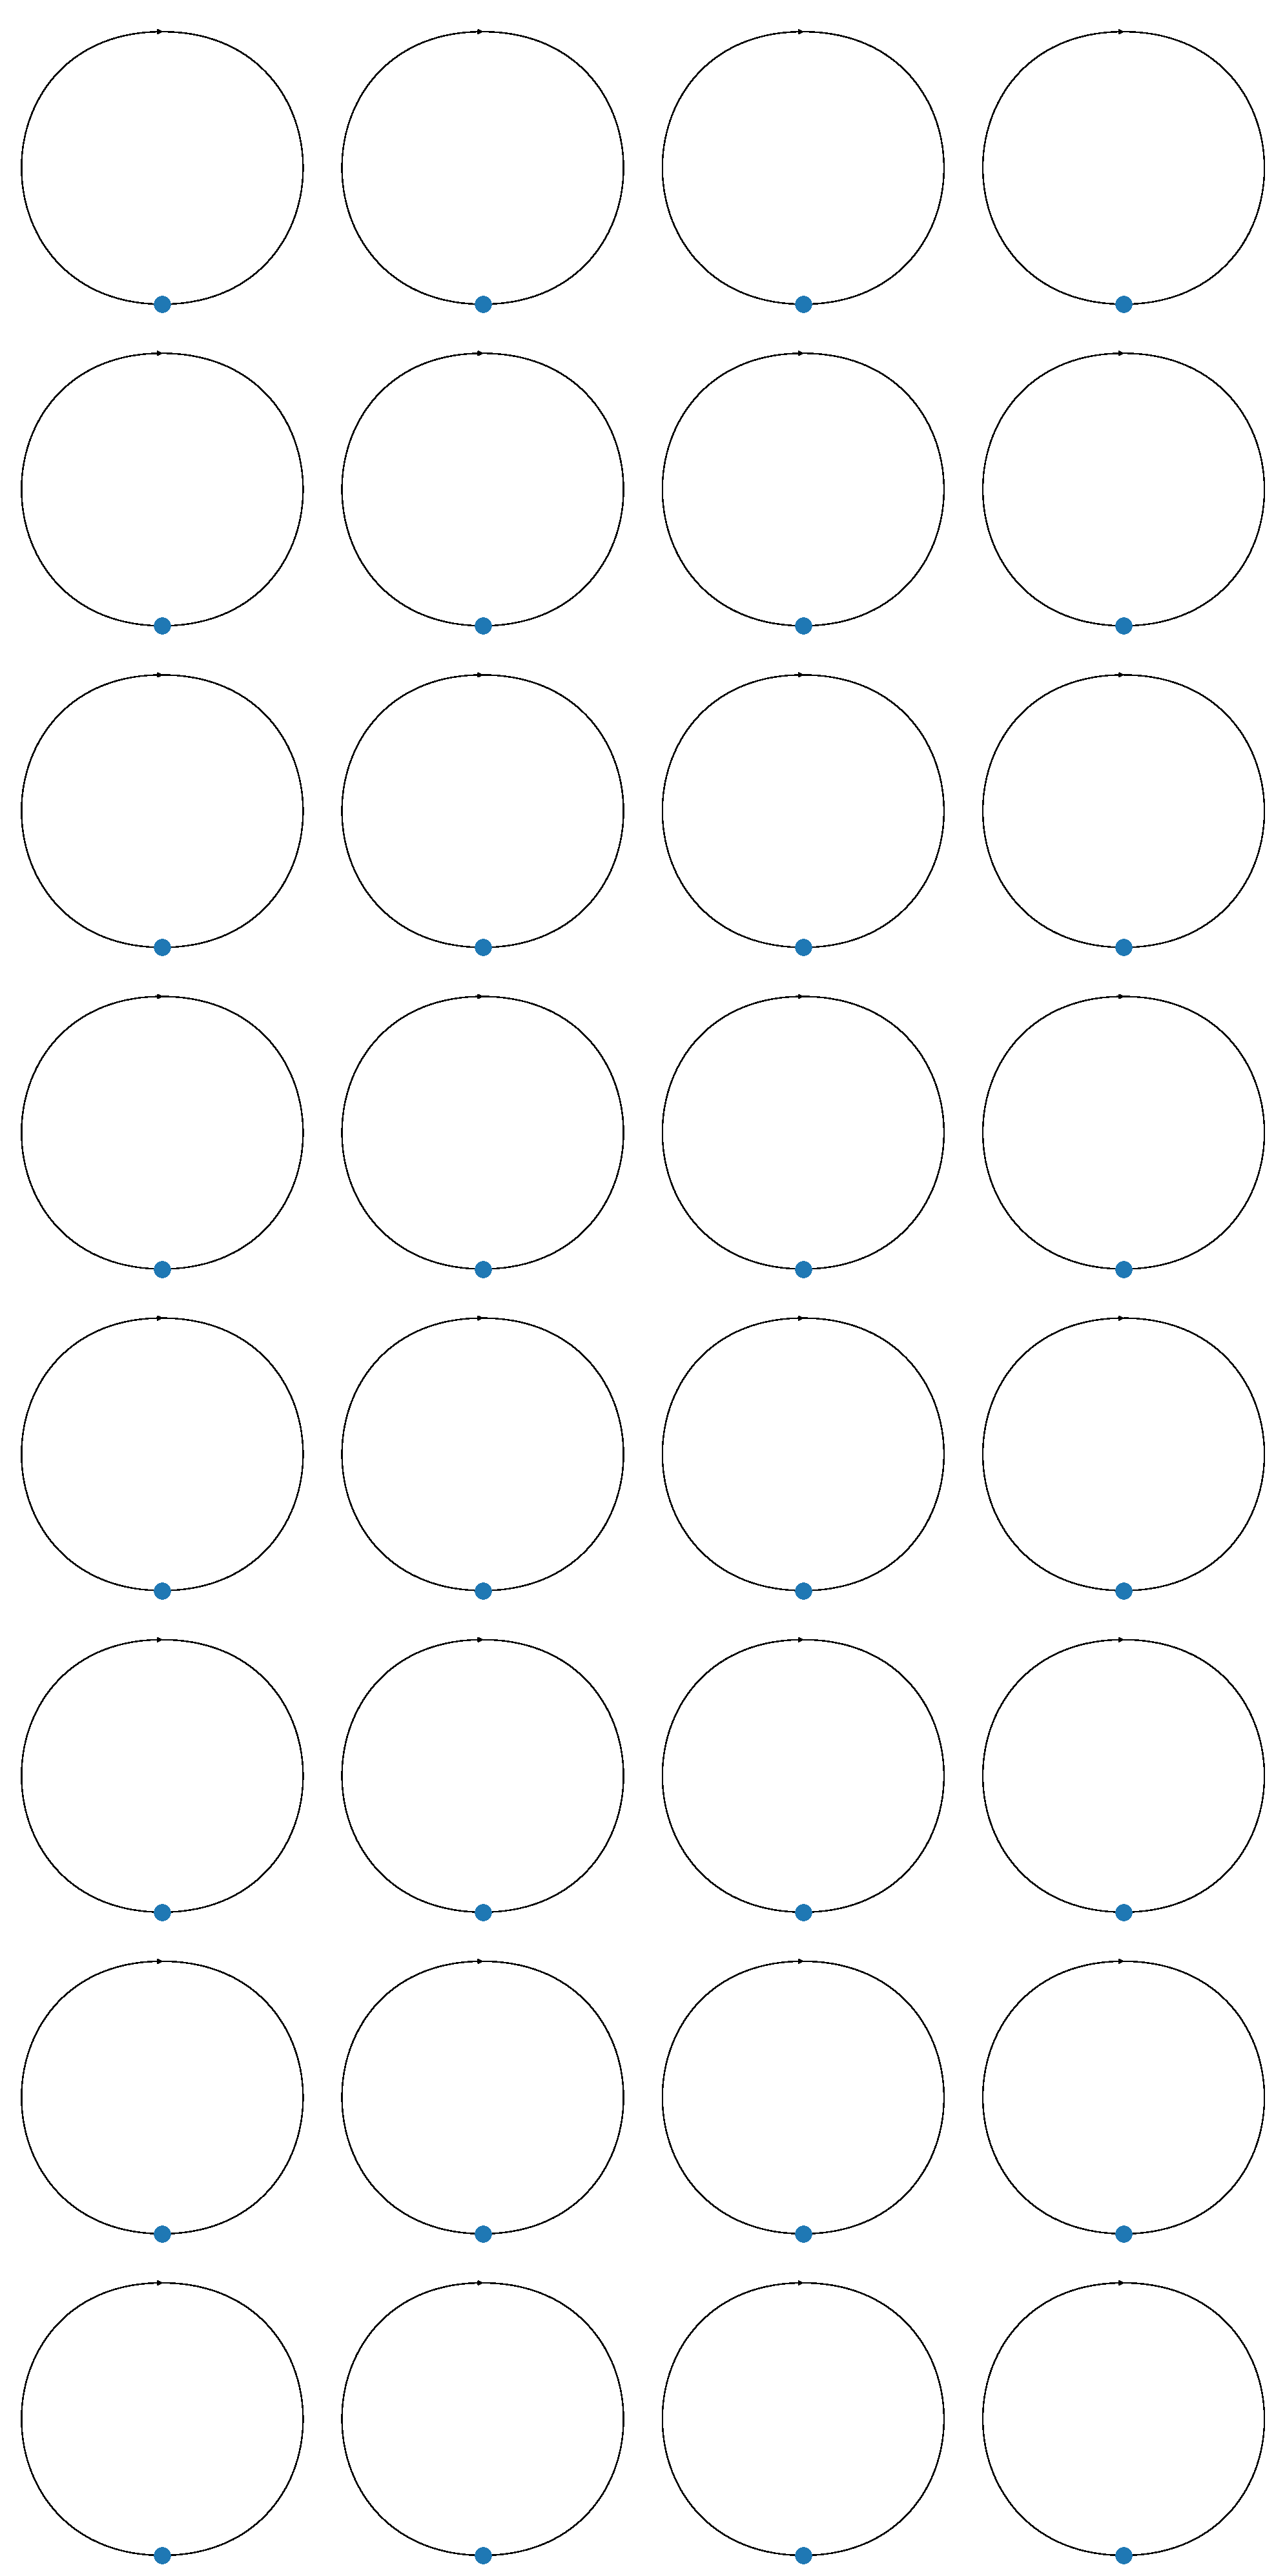

batch.G [<networkx.classes.digraph.DiGraph object at 0x7f9b735dd2a0>, <networkx.classes.digraph.DiGraph object at 0x7f9b735dd330>, <networkx.classes.digraph.DiGraph object at 0x7f9b735dd3c0>, <networkx.classes.digraph.DiGraph object at 0x7f9b735dd450>, <networkx.classes.digraph.DiGraph object at 0x7f9b735dd4e0>, <networkx.classes.digraph.DiGraph object at 0x7f9b735dd570>, <networkx.classes.digraph.DiGraph object at 0x7f9b735dd600>, <networkx.classes.digraph.DiGraph object at 0x7f9b735dd690>, <networkx.classes.digraph.DiGraph object at 0x7f9b735dd720>, <networkx.classes.digraph.DiGraph object at 0x7f9b735dd7b0>, <networkx.classes.digraph.DiGraph object at 0x7f9b735dd840>, <networkx.classes.digraph.DiGraph object at 0x7f9b735dd8d0>, <networkx.classes.digraph.DiGraph object at 0x7f9b735dd960>, <networkx.classes.digraph.DiGraph object at 0x7f9b735dd9f0>, <networkx.classes.digraph.DiGraph object at 0x7f9b735dda80>, <networkx.classes.digraph.DiGraph object at 0x7f9b735ddb10>, <networkx.class

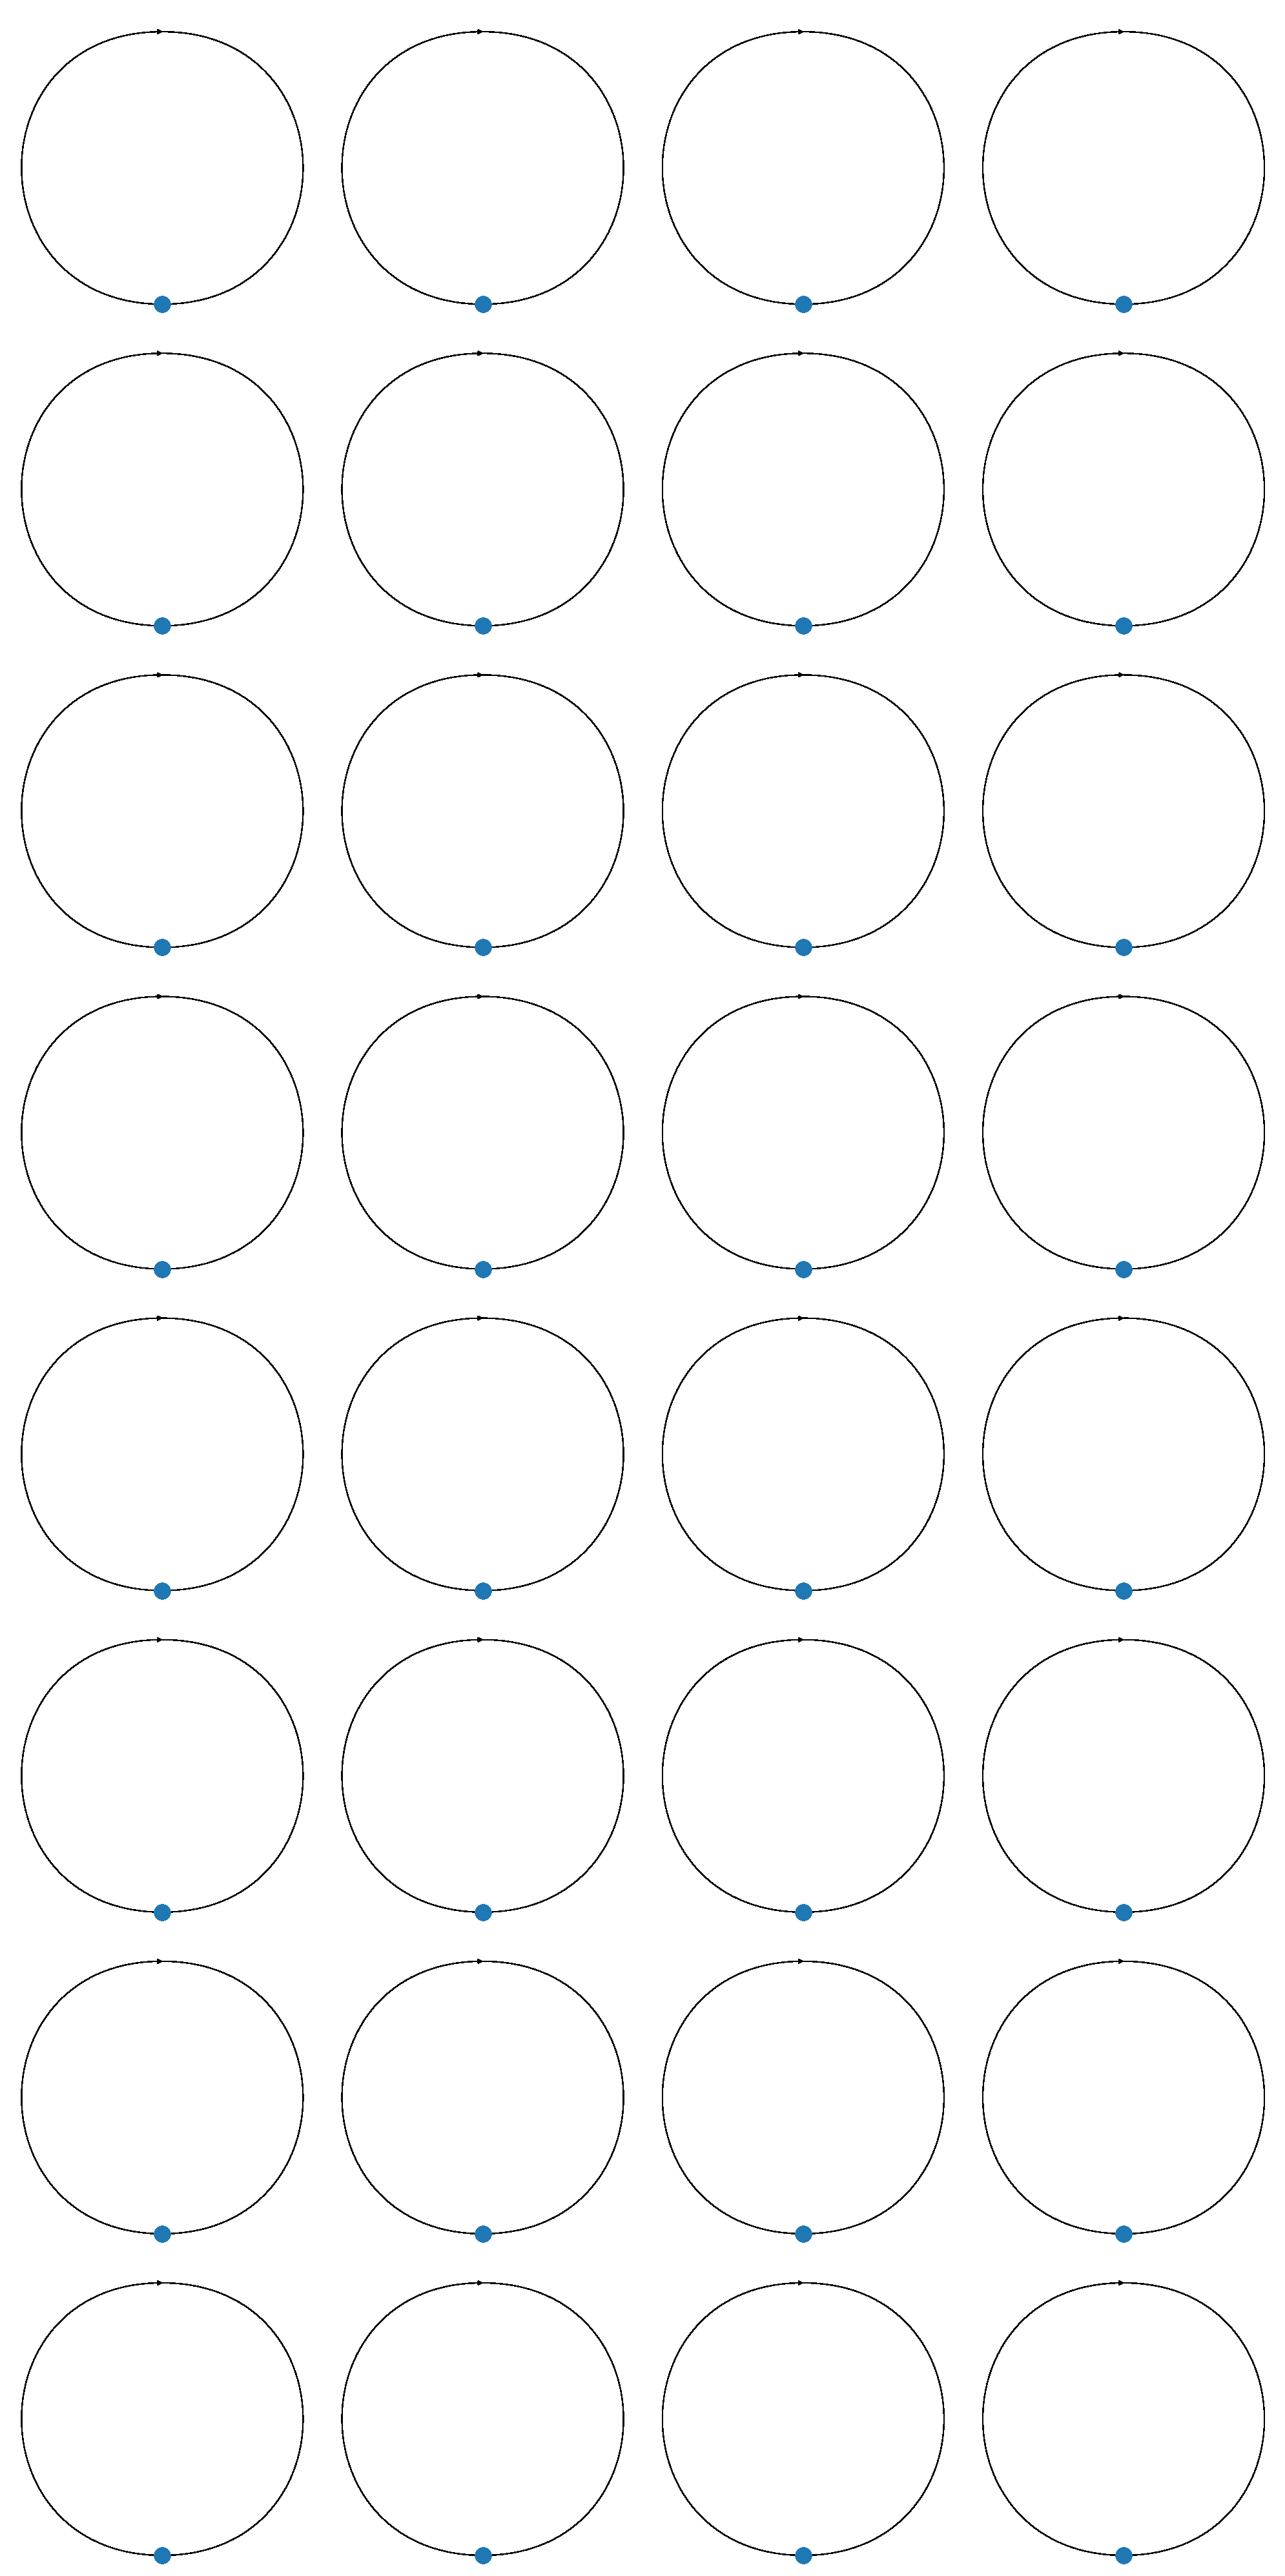

batch.G [<networkx.classes.digraph.DiGraph object at 0x7f9b735de4a0>, <networkx.classes.digraph.DiGraph object at 0x7f9b735de530>, <networkx.classes.digraph.DiGraph object at 0x7f9b735de5c0>, <networkx.classes.digraph.DiGraph object at 0x7f9b735de650>, <networkx.classes.digraph.DiGraph object at 0x7f9b735de6e0>, <networkx.classes.digraph.DiGraph object at 0x7f9b735de770>, <networkx.classes.digraph.DiGraph object at 0x7f9b735de800>, <networkx.classes.digraph.DiGraph object at 0x7f9b735de890>, <networkx.classes.digraph.DiGraph object at 0x7f9b735de920>, <networkx.classes.digraph.DiGraph object at 0x7f9b735de9b0>, <networkx.classes.digraph.DiGraph object at 0x7f9b735dea40>, <networkx.classes.digraph.DiGraph object at 0x7f9b735dead0>, <networkx.classes.digraph.DiGraph object at 0x7f9b735deb60>, <networkx.classes.digraph.DiGraph object at 0x7f9b735debf0>, <networkx.classes.digraph.DiGraph object at 0x7f9b735dec80>, <networkx.classes.digraph.DiGraph object at 0x7f9b735ded10>, <networkx.class

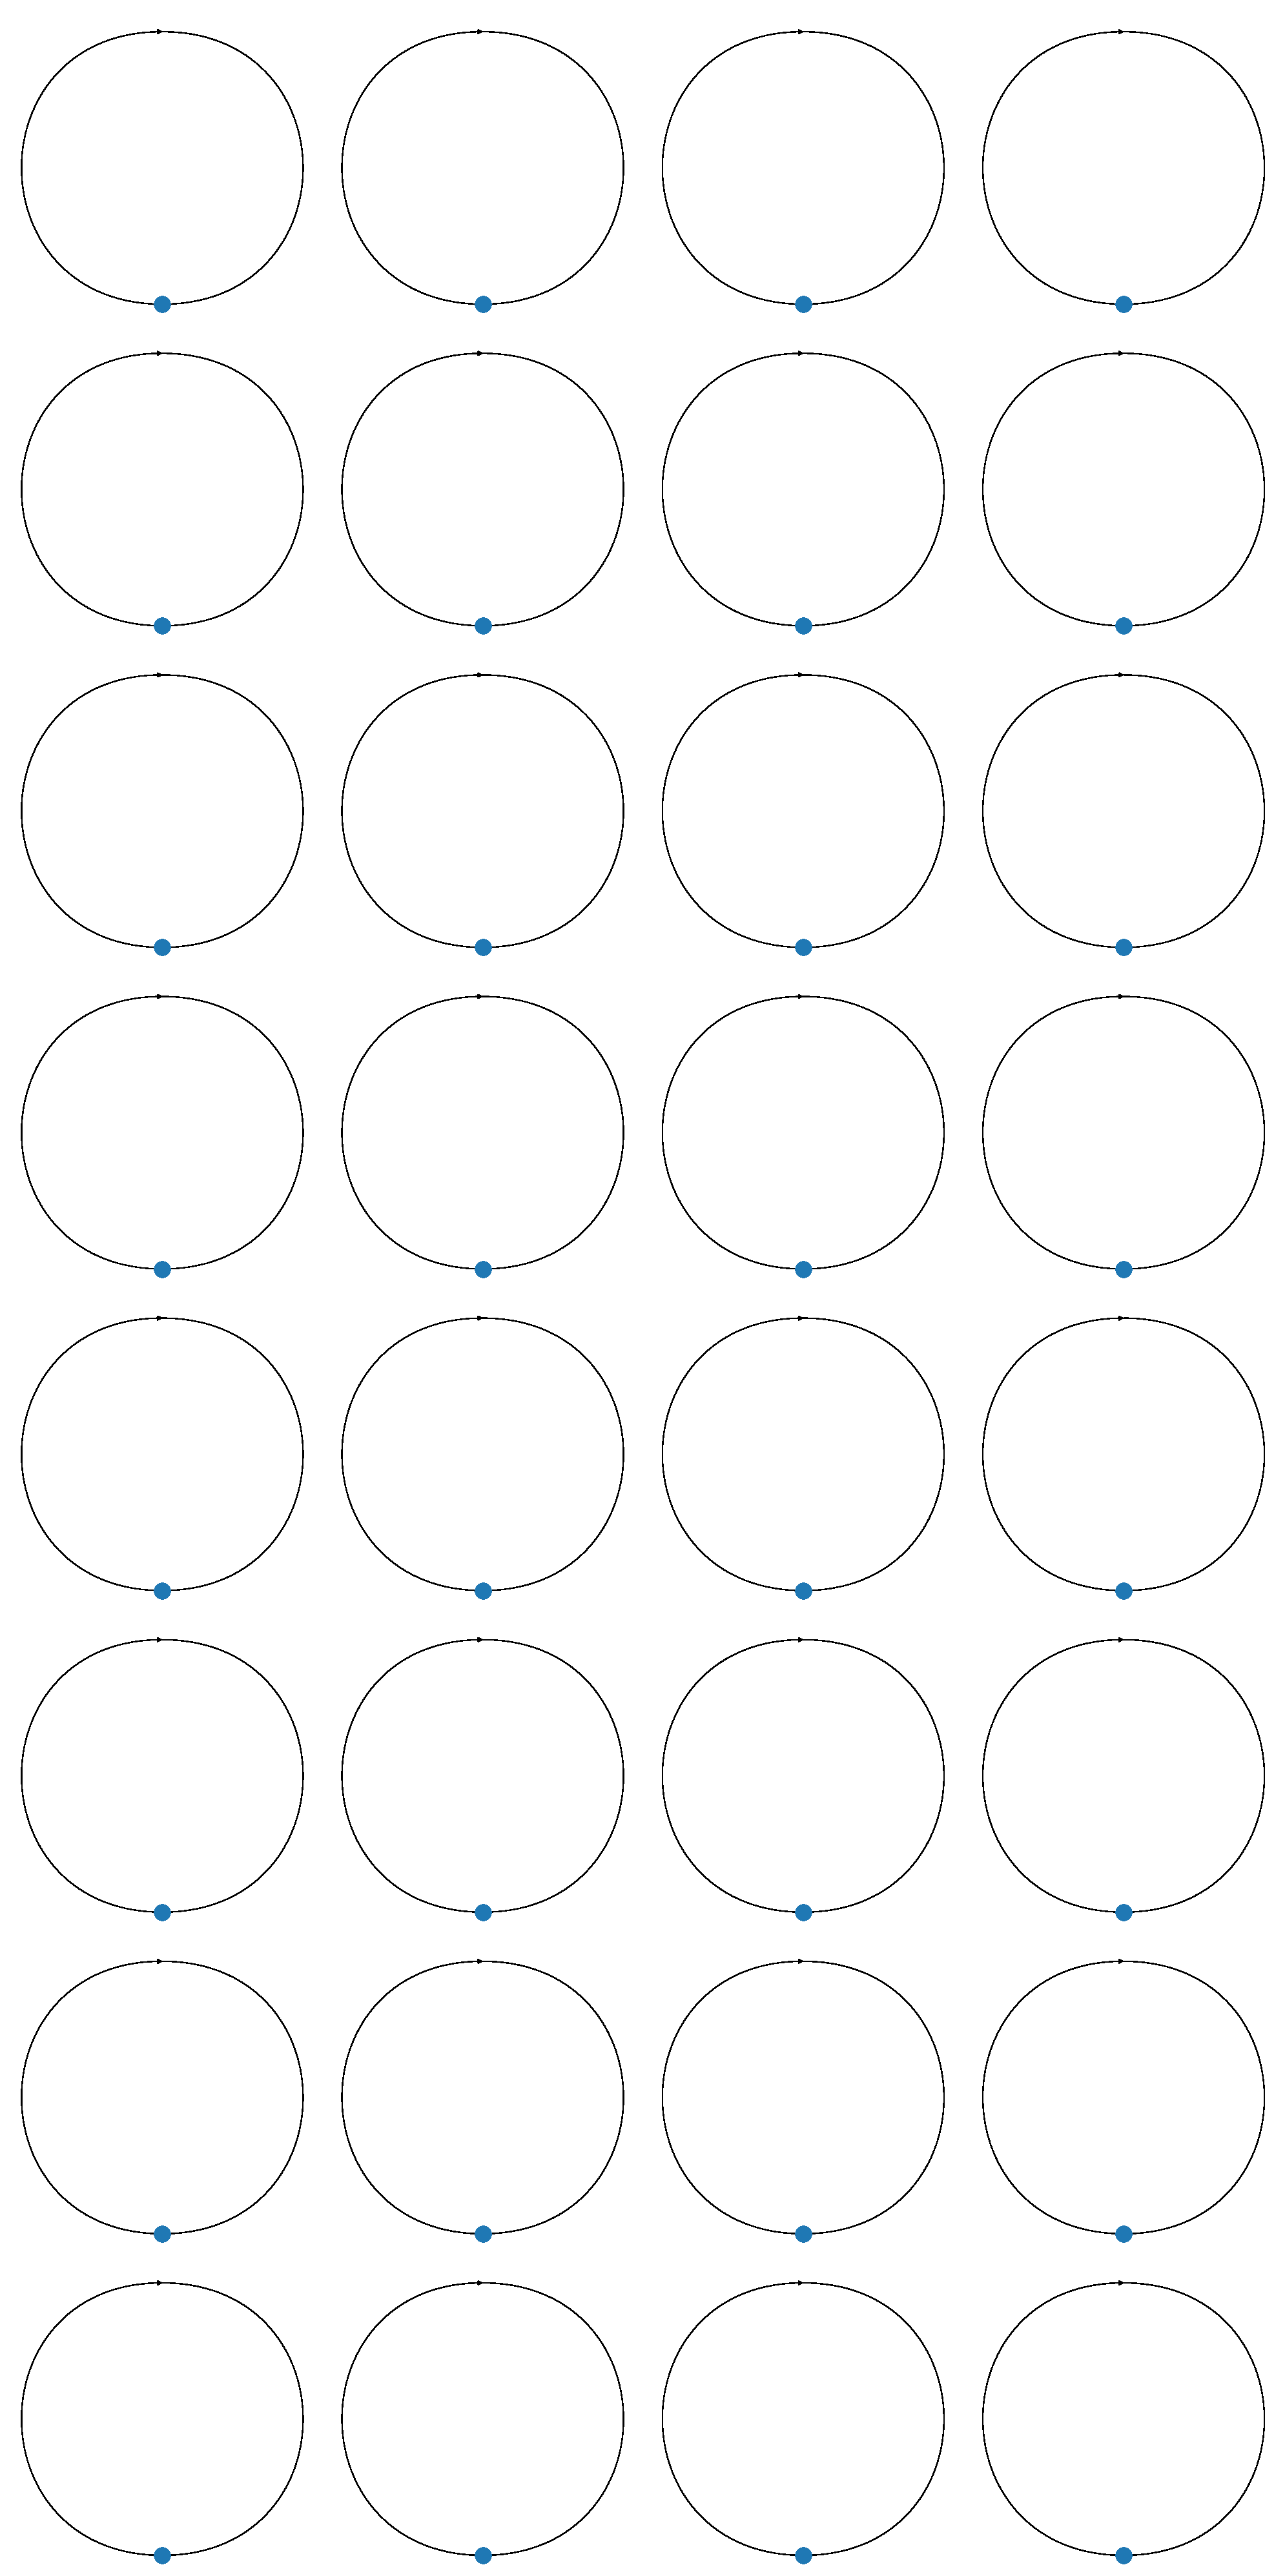

batch.G [<networkx.classes.digraph.DiGraph object at 0x7f9b735df8b0>, <networkx.classes.digraph.DiGraph object at 0x7f9b735df940>, <networkx.classes.digraph.DiGraph object at 0x7f9b735df9d0>, <networkx.classes.digraph.DiGraph object at 0x7f9b735dfa60>, <networkx.classes.digraph.DiGraph object at 0x7f9b735dfaf0>, <networkx.classes.digraph.DiGraph object at 0x7f9b735dfb80>, <networkx.classes.digraph.DiGraph object at 0x7f9b735dfc10>, <networkx.classes.digraph.DiGraph object at 0x7f9b735dfca0>, <networkx.classes.digraph.DiGraph object at 0x7f9b735dfd30>, <networkx.classes.digraph.DiGraph object at 0x7f9b735dfdc0>, <networkx.classes.digraph.DiGraph object at 0x7f9b735dfe50>, <networkx.classes.digraph.DiGraph object at 0x7f9b735dfee0>, <networkx.classes.digraph.DiGraph object at 0x7f9b735dff70>, <networkx.classes.digraph.DiGraph object at 0x7f9b71848040>, <networkx.classes.digraph.DiGraph object at 0x7f9b718480d0>, <networkx.classes.digraph.DiGraph object at 0x7f9b71848160>, <networkx.class

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import math

def visualize_graph_v2(batch, perm_index, apsp_attr, pos=None):
    print("inside visualize_graph_v2", batch.G)
    total = 0
    for G in batch.G:
        total += G.number_of_nodes()
    print("total", total)
    print("dimension of shape", pos.shape)

    x = 0
    num_graphs = len(batch.G)
    num_cols = 4
    num_rows = math.ceil(num_graphs / num_cols)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*5, num_rows*5))
    axes = axes.flatten() 

    for i in range(num_graphs):
        ax = axes[i]
        graph_pos = pos[x:x + batch.G[i].number_of_nodes()]

        if torch.isnan(graph_pos).any():
            print(f"Warning: NaN values found in graph {i} positions! Replacing NaN values with (0,0).")
            graph_pos = torch.nan_to_num(graph_pos, nan=0.0)

        print(i, graph_pos)
        nx.draw_networkx(batch.G[i], pos=graph_pos.numpy(), with_labels=False, cmap="Set2", ax=ax)
        ax.set_axis_off()
        x += batch.G[i].number_of_nodes()

    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

    return batch.G[0]


with torch.no_grad():
    model.eval()
    losses = []

    for batch in tqdm(test_loader, disable=True):
        batch = batch.to(device)

        loss = 0
        for c, w in criteria.items():
            pred = model(
                init_pos=generate_init_pos(batch),
                edge_index=batch.perm_index,
                edge_attr=get_edge_features(batch.apsp_attr),
                batch_index=batch.batch,
            )
            pos = rescale_by_stress(pred, batch.apsp_attr, batch.perm_index, batch.batch)
            loss += w * c(pos, batch.perm_index, batch.apsp_attr, batch.batch)

        
        losses.append(loss.item())

        visualize_graph_v2(batch, batch.perm_index.cpu().numpy(), batch.apsp_attr.cpu().numpy(), pred)

    print(f'Test Loss: {np.mean(losses)}')

